In [1]:
from sklearn.ensemble import RandomForestRegressor
import copy
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import time
import datetime, calendar
import scipy.stats as stats
import statsmodels.api as sm
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Mecab
import nltk
import re
from collections import Counter
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from konlpy.tag import Mecab
from tensorflow.keras import layers, models
%matplotlib inline

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
train_data = pd.read_csv('train.csv')
train_data.index = pd.to_datetime(train_data['일자'])
lunch_menu = train_data['중식메뉴']
#del train_data['조식메뉴'], train_data['중식메뉴'], train_data['석식메뉴'], train_data['일자']
del train_data['일자'], train_data['조식메뉴']


cases = pd.read_csv('일일코로나확진자.csv')
cases = cases[(cases['Entity'] == 'South Korea')].iloc[:, [2, 3]].reset_index(drop=True)
cases.index = pd.to_datetime(cases['Day'])
del cases['Day']
cases.columns = ['확진자수']
cases = cases[cases.index < '2021-04-10']


temp = pd.read_csv('진주시_기온정보.csv', encoding='euc-kr')
temp.index = pd.to_datetime(temp['날짜'])
del temp['날짜'], temp['지점'], temp['최저기온(℃)']

hum = pd.read_csv('진주시강수량.csv', encoding='euc-kr')
hum.index = pd.to_datetime(hum['날짜'])
del hum['날짜'], hum['지점']
hum.fillna(0, inplace=True)


heat_idx = pd.read_csv('진주시_열지수_정보.csv', encoding='euc-kr')
heat_idx['일자'] = heat_idx['일자'].apply(lambda row: str(row)[:4] + '-' + str(row)[4:6] + '-' + str(row)[-2:])
heat_idx.index = pd.to_datetime(heat_idx['일자'])
heat_idx = heat_idx.loc[:, ['습도(%)']]

train_data = pd.concat([train_data, temp, cases, hum, heat_idx], axis=1)
train_data = train_data[~train_data['본사정원수'].isnull()].fillna(0.)
train_data.head()

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,평균기온(℃),최고기온(℃),확진자수,강수량(mm),습도(%)
2016-02-01,월,2601.0,50.0,150.0,238.0,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,-0.6,5.0,0.0,0.0,44.1
2016-02-02,화,2601.0,50.0,173.0,319.0,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,-2.3,6.2,0.0,0.0,47.2
2016-02-03,수,2601.0,56.0,180.0,111.0,0.0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,-1.7,7.7,0.0,0.0,56.2
2016-02-04,목,2601.0,104.0,220.0,355.0,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,-0.2,7.7,0.0,0.0,55.3
2016-02-05,금,2601.0,278.0,181.0,34.0,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,1.3,9.6,0.0,0.0,42.7


In [3]:
def week_of_month(dt):

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return str(int(np.ceil(adjusted_dom/7.0)))


def MunhwaDay(row):
    if row['요일'] == '수' and row['석식계'] == 0 and int(row['주차'][0]) >= 4 :
        return 1
    else:
        return 0
    
def LastWedInMonth(year, month, date):

    daysInMonth = calendar.monthrange(year, month)[1]   
    dt = datetime.date(year, month, daysInMonth)

    offset = 3 - dt.isoweekday()
    if offset > 0: offset -= 7                         
    dt += datetime.timedelta(offset)                   

    if dt == date:
        return 1
    else:
        return 0
    
train_data['개월'] = [f'{date.month}월' for date in train_data.index]
train_data['주차'] = [f'{week_of_month(date)}주차' for date in train_data.index]
train_data['문화day'] = train_data.apply(lambda row : MunhwaDay(row), axis=1)

test_data = pd.read_csv('test.csv')
test_data.index = pd.to_datetime(test_data['일자'])
#del test_data['조식메뉴'], test_data['중식메뉴'], test_data['석식메뉴'], test_data['일자']
del test_data['일자'], test_data['조식메뉴']
test_data = pd.concat([test_data, temp, cases, hum, heat_idx], axis=1)
test_data = test_data[~test_data['본사정원수'].isnull()].fillna(0.)
test_data['개월'] = [f'{date.month}월' for date in test_data.index]
test_data['주차'] = [f'{week_of_month(date)}주차' for date in test_data.index]
#test_data['문화day'] = [LastWedInMonth(date.year, date.month, date) for date in test_data.index]
test_data['문화day'] = [0 for i in range(len(test_data))]
whole_df = pd.concat([train_data, test_data], axis=0)

In [4]:
def TempClass(row):
    if row >= 30:
        return 'temp30'
    elif row >= 20:
        return 'temp20'
    elif row >= 10:
        return 'temp10'
    elif row >= 0:
        return 'temp0'
    elif row >= -10:
        return 'temp-10'
    else:
        return 'temp-20'
    
def HumidClass(row):
    if row >= 70:
        return 'Humid High'
    elif row >= 30:
        return 'Humid Middle'
    else:
        return 'Humid Low'
whole_df['본사출근자수'] = whole_df['본사정원수'] - whole_df['본사휴가자수'] - whole_df['본사출장자수'] - whole_df['현본사소속재택근무자수']
whole_df['중식 참여율'] = whole_df['중식계'] / whole_df['본사출근자수']
whole_df['석식 참여율'] = whole_df['석식계'] / whole_df['본사출근자수']
whole_df['시간외근무율'] = whole_df['본사시간외근무명령서승인건수'] / whole_df['본사출근자수']
whole_df['평균기온'] = whole_df['평균기온(℃)'].apply(TempClass)
whole_df['최고기온'] = whole_df['최고기온(℃)'].apply(TempClass)
whole_df['습도'] = whole_df['습도(%)'].apply(HumidClass)
del whole_df['본사정원수'], whole_df['본사휴가자수'], whole_df['본사출장자수'], whole_df['현본사소속재택근무자수']
del whole_df['중식계'], whole_df['석식계'], whole_df['본사시간외근무명령서승인건수']
del whole_df['평균기온(℃)'], whole_df['최고기온(℃)'], whole_df['습도(%)']
whole_df    

,요일,중식메뉴,석식메뉴,확진자수,강수량(mm),개월,주차,문화day,본사출근자수,중식 참여율,석식 참여율,시간외근무율,평균기온,최고기온,습도
2016-02-01,월,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",0.0,0.0,2월,1주차,0,2401.0,0.432736,0.137859,0.099125,temp-10,temp0,Humid Middle
2016-02-02,화,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",0.0,0.0,2월,1주차,0,2378.0,0.364592,0.235492,0.134146,temp-10,temp0,Humid Middle
2016-02-03,수,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",0.0,0.0,2월,1주차,0,2365.0,0.430021,0.242283,0.046934,temp-10,temp0,Humid Middle
2016-02-04,목,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",0.0,0.0,2월,1주차,0,2277.0,0.429513,0.230567,0.155907,temp-10,temp0,Humid Middle
2016-02-05,금,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",0.0,0.0,2월,1주차,0,2142.0,0.431839,0.154062,0.015873,temp0,temp0,Humid Middle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-05,월,쌀밥/흑미밥/찰현미밥 쇠고기미역국 춘천닭갈비 오지치즈후라이 가지두반장볶음 포기김치 ...,흑미밥 돈육고추장찌개 갈치구이 김치전 취나물무침 깍두기,478.0,0.0,4월,2주차,0,2343.0,NaN,NaN,0.300469,temp10,temp10,Humid Middle
2021-04-06,화,쌀밥/귀리밥/찰현미밥 순두부백탕 매콤소갈비찜 깻잎완자전 돌나물초장무침 포기김치 시리...,추가밥 짬뽕*생면 수제찹쌀꿔바로우 메추리알곤약장조림 단무지무침 포기김치,668.0,0.0,4월,2주차,0,2363.0,NaN,NaN,0.269149,temp10,temp20,Humid Middle
2021-04-07,수,쌀밥/흑미밥/찰현미밥 냉이국 돈육간장불고기 비빔냉면 오이나물볶음 겉절이김치 양상추샐...,단호박카레라이스 시금치된장국 소떡소떡 파프리카해초무침 감귤쥬스 포기김치,700.0,0.0,4월,2주차,0,2329.0,NaN,NaN,0.000429,temp10,temp20,Humid Middle
2021-04-08,목,쌀밥/옥수수밥/찰현미밥 맑은떡국 (New)로제찜닭 가자미구이*장 유채나물무침 포기김...,흑미밥 어묵매운탕 쇠고기숙주볶음 채소계란찜 쑥갓생무침 김치볶음,671.0,0.0,4월,2주차,0,2306.0,NaN,NaN,0.220729,temp10,temp20,Humid Middle


In [5]:
def GetMenuList(row):
    row = row.split()
    result = []
    for food in row:
        if '(' in food and ')' in food and ':' in food:
            continue
        
        if '*' in food:
            result.extend(food.split('*'))
            continue
        
        food = re.sub('\(New\)', '', food)
        food = re.sub('/\w+', '', food)
        
        result.append(food)
    return result

whole_df['중식메뉴'] = whole_df['중식메뉴'].apply(GetMenuList)
whole_df['석식메뉴'] = whole_df['석식메뉴'].apply(GetMenuList)
menu = whole_df[['중식메뉴', '석식메뉴']]
del whole_df['중식메뉴'], whole_df['석식메뉴']
whole_df.head()

,요일,확진자수,강수량(mm),개월,주차,문화day,본사출근자수,중식 참여율,석식 참여율,시간외근무율,평균기온,최고기온,습도
2016-02-01,월,0.0,0.0,2월,1주차,0,2401.0,0.432736,0.137859,0.099125,temp-10,temp0,Humid Middle
2016-02-02,화,0.0,0.0,2월,1주차,0,2378.0,0.364592,0.235492,0.134146,temp-10,temp0,Humid Middle
2016-02-03,수,0.0,0.0,2월,1주차,0,2365.0,0.430021,0.242283,0.046934,temp-10,temp0,Humid Middle
2016-02-04,목,0.0,0.0,2월,1주차,0,2277.0,0.429513,0.230567,0.155907,temp-10,temp0,Humid Middle
2016-02-05,금,0.0,0.0,2월,1주차,0,2142.0,0.431839,0.154062,0.015873,temp0,temp0,Humid Middle


In [6]:
def PreHolyday(row, pre_hol):
    if row in pre_hol.values:
        return 1
    else:
        return 0
    
pre_hol = pd.read_csv('pre_holiday.txt', encoding='utf8')
pre_hol = pd.to_datetime(pre_hol['공휴일전평일'])
whole_df['pre공휴일'] = [PreHolyday(date, pre_hol) for date in whole_df.index]

day_dummy = pd.get_dummies(whole_df['요일'])
month_dummy = pd.get_dummies(whole_df['개월'])
week_dummy = pd.get_dummies(whole_df['주차'])
avgtemp_dummy = pd.get_dummies(whole_df[['평균기온']])
hightemp_dummy = pd.get_dummies(whole_df[['최고기온']])
humid_dummy = pd.get_dummies(whole_df['습도'])
whole_df = pd.concat([whole_df, day_dummy, month_dummy, week_dummy,
                      avgtemp_dummy, hightemp_dummy, humid_dummy], axis=1)
drop_cols = ['요일', '개월', '주차', '평균기온', '최고기온', '습도']
whole_df.drop(drop_cols, axis=1, inplace=True)
whole_df = sm.add_constant(whole_df)
train_y_lunch = whole_df['중식 참여율'].dropna()
train_y_dinner = whole_df['석식 참여율'].dropna()
del whole_df['중식 참여율'], whole_df['석식 참여율']
whole_df['4주x금요일'] = whole_df['4주차'] * whole_df['금']
whole_df['5주x금요일'] = whole_df['5주차'] * whole_df['금']


In [7]:
train_x, test_x = copy.deepcopy(whole_df.iloc[:len(train_data),:]), copy.deepcopy(whole_df.iloc[len(train_data):,:])
rain_min = train_x['강수량(mm)'].min()
rain_max = train_x['강수량(mm)'].max()
train_x['강수량(mm)'] = (train_x['강수량(mm)'] - rain_min) / (rain_max - rain_min)
test_x['강수량(mm)'] = (test_x['강수량(mm)'] - rain_min) / (rain_max - rain_min)

case_min = train_x['확진자수'].min()
case_max = train_x['확진자수'].max()

train_x['확진자수'] = (train_x['확진자수'] - case_min) / (case_max - case_min)
test_x['확진자수'] = (test_x['확진자수'] - case_min) / (case_max - case_min)

to_min = train_x['본사출근자수'].min()
to_max = train_x['본사출근자수'].max()

train_x['본사출근자수'] = (train_x['본사출근자수'] - to_min) / (to_max - to_min)
test_x['본사출근자수'] = (test_x['본사출근자수'] - to_min) / (to_max - to_min)

In [8]:
#RandomForest model
model_lunch = RandomForestRegressor(n_jobs=-1, random_state=42)
model_dinner = RandomForestRegressor(n_jobs=-1, random_state=42)
model_lunch.fit(train_x, train_y_lunch)
model_dinner.fit(train_x, train_y_dinner)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [9]:
#const_matrix = np.zeros((len(train_x), len(train_x.columns)))
#const_matrix[:,0] = 1.
#lunch_pref = train_y_lunch - res1.predict(const_matrix)
#dinner_pref = train_y_dinner - res2.predict(const_matrix)
lunch_pref = train_y_lunch - model_lunch.predict(train_x)
dinner_pref = train_y_dinner - model_dinner.predict(train_x)

In [10]:
f = open('menu.txt', 'w')
for _, row in menu.iloc[:len(train_data),:].iterrows():
    [f.write(x + ' ') for x in row['중식메뉴']]
    f.write('\n')
    [f.write(x + ' ') for x in row['석식메뉴']]
f.close()

In [11]:
import fasttext

In [12]:
model = fasttext.train_unsupervised("menu.txt", model='skipgram', lr=0.05, dim=30, ws=5, epoch=5)
model.save_model("model_file.bin")

In [13]:
def MenuVectorize(row, list_):
    vector = np.zeros(30)
    for x in row:
        vector += model[x]
    
    list_.append(list(vector / len(row)))

train_menu_lunch = []
menu['중식메뉴'].apply(lambda row : MenuVectorize(row, train_menu_lunch))
train_menu_lunch = np.array(train_menu_lunch)

train_menu_dinner = []
menu['석식메뉴'].apply(lambda row : MenuVectorize(row, train_menu_dinner));
train_menu_dinner = np.array(train_menu_dinner)

In [14]:
train_menu = pd.DataFrame(train_menu_lunch)[:-50].append(pd.DataFrame(train_menu_dinner)[:-50]).values
train_menu[np.isnan(train_menu)] = 0.
train_pref = lunch_pref.append(dinner_pref).values

In [15]:
print(train_menu.shape)
print(train_pref.shape)

(2410, 30)
(2410,)


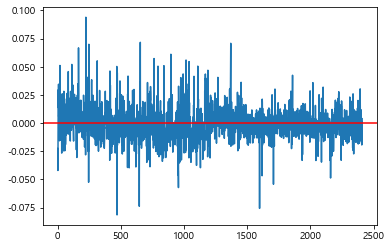

In [16]:
plt.plot(range(len(train_pref)), train_pref)
plt.axhline(0, color='r')

In [17]:
train_pref

array([-0.02269595, -0.04210324, -0.00719501, ..., -0.0077113 ,
       -0.01762987,  0.00387167])

In [30]:
train_y_lunch.mean()

0.3764582542741489

In [29]:
train_y_lunch[train_x.index == '2019-07-12']

2019-07-12    0.38733
Name: 중식 참여율, dtype: float64

In [25]:
menu.iloc[:1205][train_pref[:1205] > 0.05]

,중식메뉴,석식메뉴
2016-02-29,"[쌀밥, 얼갈이된장국, 제육볶음, 늙은호박전, 치커리생채, 요구르트, 포기김치]","[쌀밥, 버섯들깨탕, 꽁치한마리구이, 두부양념조림, 구이김, 포기김치]"
2016-07-15,"[쌀밥, 북어계란국, 등갈비김치찜, 삼치구이, 가지나물, 열무김치]","[쌀밥, 오징어국, 쇠고기장조림, 어묵볶음, 아삭고추무침, 포기김치]"
2016-10-05,"[쌀밥, 차돌박이찌개, 매운주꾸미볶음, 모둠소세지구이, 콩나물무침, 포기김치]","[쌀밥, 순두부찌개, 미니함박조림, 실곤약초무침, 취나물, 포기김치]"
2016-12-26,"[쌀밥, 동태찌개, 돈육간장불고기, 두부새싹구이, 풋마늘대무침, 포기김치]","[쌀밥, 청국장찌개, 가자미양념찜, 훈제오리냉채, 김구이, 깍두기]"
2017-01-31,"[쌀밥, 미역국, 언양식불고기, 양파채, 양잡피잡채, 진미채무침, 포기김치]","[김치볶음밥, 꼬지어묵우동, 해물까스, 탈탈소스, 콘샐러드, 내사랑포도, 포기김치]"
2017-05-10,"[쌀밥, 된장찌개, 제육볶음, 잡채, 콩나물무침, 포기김치]","[쌀밥, 연두부탕, 닭오븐구이, 해물김치전, 취나물된장무침, 포기김치]"
2017-12-26,"[쌀밥, 꽃게탕, 언양식불고기, 날치알계란찜, 호박나물, 포기김치]","[쌀밥, 청국장찌개, 돈육계란장조림, 꽃맛살볶음, 도라지오이생채, 포기김치]"
2018-10-11,"[쌀밥, 들깨버섯국, 오징어볶음, 단호박계란찜, 청경채사과무침, 포기김치]","[김치주먹밥, 우동, 타코야끼, 콥샐러드, 귤, 열무김치]"
2019-03-21,"[쌀밥, 미역국, 한방소갈비찜, 동태전, 봄동겉절이, 식혜,오렌지,바나나, 깍두기]","[빠에야, 쌀국수, 수제고로케, 과일샐러드, 양배추피클, 포기김치]"
2019-05-07,"[쌀밥, 어묵국, 훈제오리구이, 두부조림, 양파절임, 포기김치]","[쌀밥, 콩나물국, 닭갈비, 동그랑땡전, 무생채, 열무김치]"


In [40]:
pref_res = RandomForestRegressor(n_jobs=-1, random_state=42)
pref_res.fit(train_menu.astype(float), train_pref.astype(float))

RandomForestRegressor(n_jobs=-1, random_state=42)

In [42]:
test_menu_lunch = pref_res.predict(train_menu_lunch[-50:])
test_menu_dinner = pref_res.predict(train_menu_dinner[-50:])

In [48]:
X = copy.deepcopy(train_x.iloc[:,:])
X['lunch_pref'] = lunch_pref
model1 = RandomForestRegressor(n_jobs=-1, random_state=42)
model1.fit(X, train_y_lunch)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [49]:
X = copy.deepcopy(train_x.iloc[:,:])
X['dinner_pref'] = dinner_pref
model2 = RandomForestRegressor(n_jobs=-1, random_state=42)
model2.fit(X, train_y_dinner)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [76]:
sub = pd.read_csv('sample_submission.csv')
X = copy.deepcopy(test_x.iloc[:,:])
X['lunch_pref'] = test_menu_lunch
sub['중식계'] = (model1.predict(X) * whole_df['본사출근자수'][-50:].values).round()

X = copy.deepcopy(test_x.iloc[:,:])
X['dinner_pref'] = test_menu_dinner
sub['석식계'] = (model2.predict(X) * whole_df['본사출근자수'][-50:].values).round()

sub.to_csv('submission_Pref_RF.csv', index=False)


In [89]:
sub = pd.read_csv('sample_submission.csv')
X = copy.deepcopy(test_x.iloc[:,:])
X['lunch_pref'] = test_menu_lunch * 10
sub['중식계'] = (model1.predict(X) * whole_df['본사출근자수'][-50:].values).round()

X = copy.deepcopy(test_x.iloc[:,:])
X['dinner_pref'] = test_menu_dinner * 10
sub['석식계'] = (model2.predict(X) * whole_df['본사출근자수'][-50:].values).round()

sub.to_csv('submission_Pref_RF_1.csv', index=False)

In [91]:
X

,const,확진자수,강수량(mm),문화day,본사출근자수,시간외근무율,pre공휴일,금,목,수,...,최고기온_temp0,최고기온_temp10,최고기온_temp20,최고기온_temp30,Humid High,Humid Low,Humid Middle,4주x금요일,5주x금요일,dinner_pref
2021-01-27,1.0,0.401778,0.000000,0,0.634603,0.002123,0,0,0,1,...,0,1,0,0,0,0,1,0,0,-0.046973
2021-01-28,1.0,0.379143,0.000000,0,0.611362,0.176369,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0.012478
2021-01-29,1.0,0.367825,0.000000,0,0.515171,0.000000,0,1,0,0,...,1,0,0,0,0,0,1,0,1,-0.003165
2021-02-01,1.0,0.271625,0.114613,0,0.624919,0.229915,0,0,0,0,...,0,1,0,0,1,0,0,0,0,-0.013318
2021-02-02,1.0,0.377526,0.000000,0,0.639122,0.192633,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0.034641
2021-02-03,1.0,0.364592,0.000000,0,0.650742,0.002101,0,0,0,1,...,1,0,0,0,0,0,1,0,0,-0.021991
2021-02-04,1.0,0.298302,0.000000,0,0.640413,0.201354,0,0,1,0,...,0,1,0,0,0,0,1,0,0,-0.012696
2021-02-05,1.0,0.317704,0.000000,0,0.564881,0.000000,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0.036218
2021-02-08,1.0,0.244139,0.000000,0,0.620400,0.295757,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0.027559
2021-02-09,1.0,0.358124,0.000000,0,0.610717,0.233822,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0.045003
